In [ ]:
!unzip Colab_test_dataset-G4-Gw.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 25 13:35:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    40W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import datetime
import numpy as np 
import pandas as pd 
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from itertools import chain
from tqdm import tqdm_notebook,tnrange
from skimage.io import imread, imshow,concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
ProjectName = "G4-Gw-FLAIR"
DataPath = '/content/Colab_test_dataset'
DataSetSplitRecord = '/content/drive/Shareddrives/Biomedical-Image-data/Result/Segmentation-CNN/Glioma-Grade4-Gw-FLAIR/DataSetSplit.xlsx'
TargetFile = "FLAIR-"
CheckpointSavePath = '/content/drive/Shareddrives/Biomedical-Image-data/Result/Segmentation-CNN/Glioma-Grade4-Gw-FLAIR/' + ProjectName
CheckpointLoadPath = '/content/drive/Shareddrives/Biomedical-Image-data/Result/Segmentation-CNN/Glioma-Grade4-Gw-FLAIR/' + ProjectName
EPOCHS = 150
BATCH_SIZE = 64
ImgHeight = 240
ImgWidth = 240
Channels = 3

In [ ]:
subjects = []
images = []
masks = []

def find_files(file_path):
    files = os.listdir(file_path) 
    for file in files:
        npath = file_path + '/' + file                                 
        if TargetFile in file:
          subjects.append(str(file).split("_")[0])
          images.append(file)
          masks.append(file.replace(TargetFile,"tumor_segmentation-"))      
        if os.path.isdir(npath):   
            if file[0] == '.':
                pass
            else:
                find_files(npath)                

find_files(DataPath)

In [ ]:
len(subjects),len(images),len(masks)

(15729, 15729, 15729)

In [ ]:
imageset_df = pd.DataFrame({'subjects':subjects, 'images':images, 'masks':masks,})
imageset_df.head(15)

,subjects,images,masks
0,UCSF-PDGM-0275,UCSF-PDGM-0275_FLAIR-101.png,UCSF-PDGM-0275_tumor_segmentation-101.png
1,UCSF-PDGM-0182,UCSF-PDGM-0182_FLAIR-078.png,UCSF-PDGM-0182_tumor_segmentation-078.png
2,UCSF-PDGM-0087,UCSF-PDGM-0087_FLAIR-072.png,UCSF-PDGM-0087_tumor_segmentation-072.png
3,UCSF-PDGM-0090,UCSF-PDGM-0090_FLAIR-044.png,UCSF-PDGM-0090_tumor_segmentation-044.png
4,UCSF-PDGM-0377,UCSF-PDGM-0377_FLAIR-062.png,UCSF-PDGM-0377_tumor_segmentation-062.png
5,UCSF-PDGM-0426,UCSF-PDGM-0426_FLAIR-099.png,UCSF-PDGM-0426_tumor_segmentation-099.png
6,UCSF-PDGM-0317,UCSF-PDGM-0317_FLAIR-089.png,UCSF-PDGM-0317_tumor_segmentation-089.png
7,UCSF-PDGM-0137,UCSF-PDGM-0137_FLAIR-123.png,UCSF-PDGM-0137_tumor_segmentation-123.png
8,UCSF-PDGM-0434,UCSF-PDGM-0434_FLAIR-095.png,UCSF-PDGM-0434_tumor_segmentation-095.png
9,UCSF-PDGM-0278,UCSF-PDGM-0278_FLAIR-060.png,UCSF-PDGM-0278_tumor_segmentation-060.png


In [ ]:
df = pd.DataFrame({'directory_image':DataPath + "/" + TargetFile.replace("-","") + "/" + imageset_df['images'], 'directory_mask':DataPath + "/TumorSegmentation/" + imageset_df['masks'],})

In [ ]:
def plot_images(index):
    
    imagePath = os.path.join(df['directory_image'].iloc[index])
    maskPath = os.path.join(df['directory_mask'].iloc[index])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig,axs = plt.subplots(1,3, figsize=[13,15])
    
    axs[0].imshow(image)
    axs[0].set_title("Brain MRI Slice")
    
    plt.grid(False)
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    plt.grid(False)
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.25)    
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

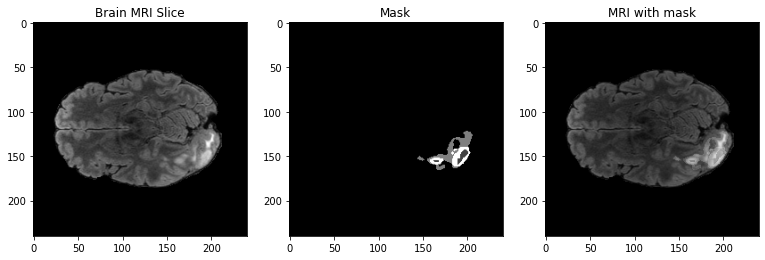

In [ ]:
plot_images(25)

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.15, shuffle = True)
df_train, df_test = train_test_split(df_train, test_size=0.25, shuffle = True)

with pd.ExcelWriter(DataSetSplitRecord) as writer:
  df_train.to_excel(writer,sheet_name='Train',index=False)
  df_val.to_excel(writer,sheet_name='Validation',index=False)
  df_test.to_excel(writer,sheet_name='Test',index=False)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(10026, 2)
(2360, 2)
(3343, 2)


In [ ]:
df.head(15)

,directory_image,directory_mask
0,/content/Colab_test_dataset/FLAIR/UCSF-PDGM-02...,/content/Colab_test_dataset/TumorSegmentation/...
1,/content/Colab_test_dataset/FLAIR/UCSF-PDGM-01...,/content/Colab_test_dataset/TumorSegmentation/...
2,/content/Colab_test_dataset/FLAIR/UCSF-PDGM-00...,/content/Colab_test_dataset/TumorSegmentation/...
3,/content/Colab_test_dataset/FLAIR/UCSF-PDGM-00...,/content/Colab_test_dataset/TumorSegmentation/...
4,/content/Colab_test_dataset/FLAIR/UCSF-PDGM-03...,/content/Colab_test_dataset/TumorSegmentation/...
5,/content/Colab_test_dataset/FLAIR/UCSF-PDGM-04...,/content/Colab_test_dataset/TumorSegmentation/...
6,/content/Colab_test_dataset/FLAIR/UCSF-PDGM-03...,/content/Colab_test_dataset/TumorSegmentation/...
7,/content/Colab_test_dataset/FLAIR/UCSF-PDGM-01...,/content/Colab_test_dataset/TumorSegmentation/...
8,/content/Colab_test_dataset/FLAIR/UCSF-PDGM-04...,/content/Colab_test_dataset/TumorSegmentation/...
9,/content/Colab_test_dataset/FLAIR/UCSF-PDGM-02...,/content/Colab_test_dataset/TumorSegmentation/...


In [ ]:
def adjust(img,mask):
    #normalization
    img = img / 255.
    #mask
    mask = mask / 255.
    mask[mask > 0.1] = 1
    mask[mask <= 0.1] = 0
    return (img, mask)

In [ ]:
data_augmentation = dict(rotation_range=0,
                        width_shift_range=0,
                        height_shift_range=0,
                        shear_range=0,
                        zoom_range=0,
                        horizontal_flip=False,
                        fill_mode='nearest')

In [ ]:
def train_generator(dataframe, batch_size, aug_dict, 
                    image_color_mode = "rgb",
                    mask_color_mode = "grayscale",
                    image_save_prefix = "image",
                    mask_save_prefix = "mask",
                    save_to_dir = None,
                    target_size = (240,240),
                    seed = 1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

  #image
    image_generator = image_datagen.flow_from_dataframe(
          dataframe,
          x_col = "directory_image",
          target_size = target_size,
          batch_size = batch_size,
          class_mode = None,
          color_mode = image_color_mode,
          save_to_dir = save_to_dir,
          save_prefix = image_save_prefix,
          seed = seed )

   #mask
    mask_generator = mask_datagen.flow_from_dataframe(
          dataframe,
          x_col = "directory_mask",
          target_size = target_size,
          batch_size = batch_size,
          class_mode = None,
          color_mode = mask_color_mode,
          save_to_dir = save_to_dir,
          save_prefix = mask_save_prefix,
          seed = seed)
  
  #combining the generators to make a whole generator
    train_gen = zip(image_generator, mask_generator)

  #data adjustment
    for (img, mask) in train_gen:
        img, mask = adjust(img, mask)
        yield (img,mask)

In [ ]:
IMG_SIZE = (240,240)
train_gen = train_generator(df_train, batch_size= BATCH_SIZE, 
                            aug_dict = data_augmentation,
                            target_size = IMG_SIZE)
val_gen = train_generator(df_val, batch_size = BATCH_SIZE,
                           aug_dict = dict(),
                           target_size = IMG_SIZE)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def UNET(input_img, n_filters = 32, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
def iou(ytrue, ypred):
    smoothing_factor= 0.0000001
    intersection = K.sum(ytrue*ypred)
    combined_area = K.sum(ytrue+ypred)
    union_area = combined_area - intersection
    iou = (intersection+smoothing_factor)/(union_area+smoothing_factor)
    return iou

def jac_distance(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    return -iou(y_true, y_pred)

# Dice Score
def dice_coef(ytrue, ypred):
    smoothing_factor=0.1
    intersection = K.sum(ytrue*ypred)
    ytrue_area = K.sum(ytrue)
    ypred_area = K.sum(ypred)
    
    combined_area = ytrue_area + ypred_area
    dice = 2*((intersection+smoothing_factor)/(combined_area+smoothing_factor))
    return dice

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
learning_rate = 0.05
decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate, epsilon= 0.1, decay=decay_rate, amsgrad=False)

In [ ]:
input_img = Input((ImgHeight,ImgWidth,3), name='img')
model = UNET(input_img, n_filters=64, dropout=0.2, batchnorm=True)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy", iou, dice_coef,tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 240, 240, 64  1792        ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 240, 240, 64  256        ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

In [ ]:
#Test
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
callbacks = [
    EarlyStopping(monitor='dice_coef',patience=10, verbose=1),
    ReduceLROnPlateau(monitor='dice_coef',factor=0.2, patience=10, min_lr=0.0001, verbose=1),
    ModelCheckpoint(filepath = CheckpointSavePath, verbose=1, save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.TensorBoard(log_dir="./logs") # test
]

In [ ]:
%tensorboard --logdir logs # test

In [ ]:
results = model.fit(train_gen,
          steps_per_epoch = len(df_train)/BATCH_SIZE,
          epochs = EPOCHS,
          callbacks = callbacks,
          validation_data = val_gen,
          validation_steps = len(df_val)/BATCH_SIZE) 

Found 10026 validated image filenames.
Found 10026 validated image filenames.
Epoch 1/150
157/156 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9547 - iou: 0.1862 - dice_coef: 0.3062 - precision_1: 0.3206Found 2360 validated image filenames.
Found 2360 validated image filenames.

Epoch 1: val_loss improved from inf to 0.07006, saving model to /content/drive/Shareddrives/Biomedical-Image-data/Result/Segmentation-CNN/Glioma-Grade4-Gw-FLAIR/G4-Gw-FLAIR
156/156 [==============================] - 58s 357ms/step - loss: 0.1253 - accuracy: 0.9547 - iou: 0.1862 - dice_coef: 0.3062 - precision_1: 0.3206 - val_loss: 0.0701 - val_accuracy: 0.9759 - val_iou: 0.2102 - val_dice_coef: 0.3473 - val_precision_1: 0.7807 - lr: 0.0500
Epoch 2/150
157/156 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9792 - iou: 0.3355 - dice_coef: 0.5017 - precision_1: 0.7640
Epoch 2: val_loss did not improve from 0.07006
156/156 [==============================] - 55s 34

In [ ]:
model.load_weights(CheckpointLoadPath)

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMG_SIZE)
"accuracy", iou, dice_coef,tf.keras.metrics.Precision()

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test loss: ",results[0])
# print("Test Accuracy: ",results[1])
print("Test IoU: ",results[2])
print("Test Dice Coefficient: ",results[3])
print("Test Precision: ",results[4])

Found 3343 validated image filenames.
Found 3343 validated image filenames.
52/52 [==============================] - 8s 151ms/step - loss: 0.0276 - accuracy: 0.9907 - iou: 0.7317 - dice_coef: 0.8449 - precision_1: 0.8229
Test loss:  0.027617719024419785
Test IoU:  0.7316843867301941
Test Dice Coefficient:  0.8448745012283325
Test Precision:  0.8229072690010071


In [ ]:
#Test
#DataSetSplitRecord = '/content/DataSetSplit.xlsx'

df_testSetLoad = pd.read_excel(DataSetSplitRecord, sheet_name="Test")

test_gen = train_generator(df_testSetLoad, BATCH_SIZE,
                                dict(),
                                target_size=IMG_SIZE)
"accuracy", iou, dice_coef,tf.keras.metrics.Precision()

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test loss: ",results[0])
# print("Test Accuracy: ",results[1])
print("Test IoU: ",results[2])
print("Test Dice Coefficient: ",results[3])
print("Test Precision: ",results[4])


Found 3343 validated image filenames.
Found 3343 validated image filenames.
52/52 [==============================] - 7s 142ms/step - loss: 0.0276 - accuracy: 0.9907 - iou: 0.7317 - dice_coef: 0.8449 - precision_1: 0.8229
Test loss:  0.027617719024419785
Test IoU:  0.7316843867301941
Test Dice Coefficient:  0.8448745012283325
Test Precision:  0.8229072690010071


1/1 [==============================] - 1s 576ms/step


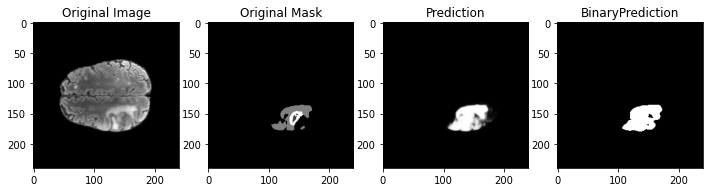

1/1 [==============================] - 0s 19ms/step


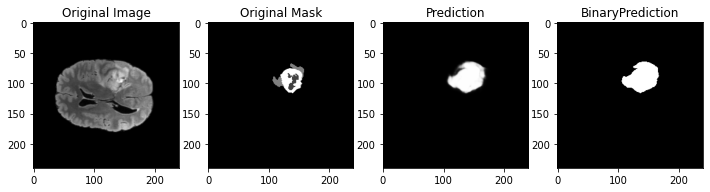

1/1 [==============================] - 0s 19ms/step


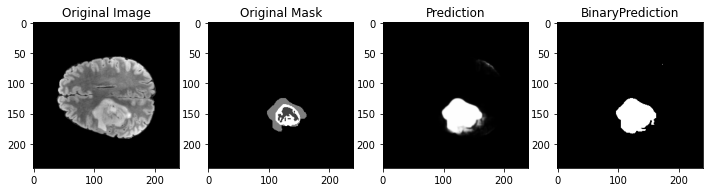

1/1 [==============================] - 0s 20ms/step


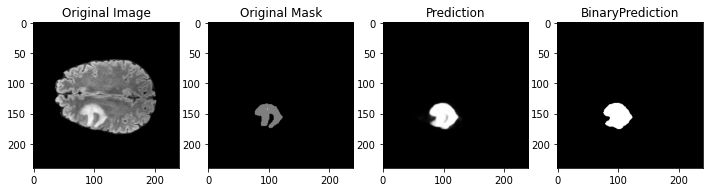

1/1 [==============================] - 0s 19ms/step


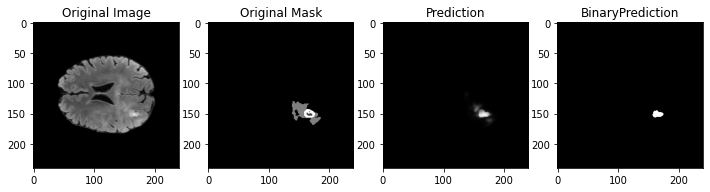

In [ ]:
for i in range(5):
    
    index = i+90
    imagePath = os.path.join(df['directory_image'].iloc[index])
    maskPath = os.path.join(df['directory_mask'].iloc[index])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    img = cv2.resize(image,(ImgHeight,ImgWidth))
    img = img/255
    img = img[np.newaxis,:,:,:]
    pred=model.predict(img)
    
    pred_2 = np.squeeze(pred, axis=(0,3))
    pred_3 = np.repeat(pred_2[:, :, np.newaxis], 3, axis=2)
    
    pred_3b = np.zeros([240,240,3])
    for i in range(240):
        for j in range(240):
            for k in range(3):
                if pred_3[i,j,k]>=0.5:
                    pred_3b[i,j,k] = 1
                else :
                    pred_3b[i,j,k] = 0
                
    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(pred_3)
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(pred_3b)
    plt.title('BinaryPrediction')
    plt.show()

In [ ]:
# test
print(pred_3.shape)
c = 0
e = 0
for i in range(240):
    for j in range(240):
            if pred_3[i,j,0]>0 and pred_3[i,j,0]==pred_3[i,j,1] and pred_3[i,j,0]==pred_3[i,j,2]:
                c = c + 1
            elif pred_3[i,j,0]>0 and (pred_3[i,j,0]!=pred_3[i,j,1] or pred_3[i,j,0]!=pred_3[i,j,2]):
                e = e + 1
print('Count = ' + str(c))
print('Error = ' + str(e))

(240, 240, 3)
Count = 57600
Error = 0
